In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'sklearn.model_selection'

### Задача 1

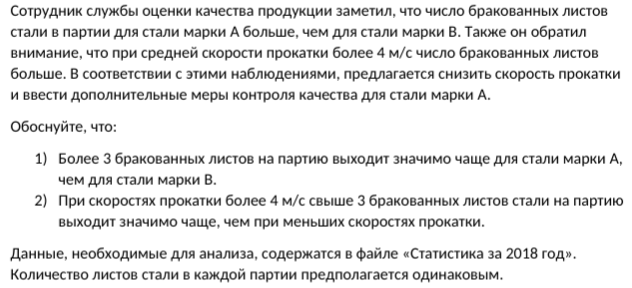

In [2]:
data = pd.read_csv('static_2018.csv')
data.head()

,Число бракованных листов,Скорость прокатки,Марка стали
0,3,3.8,A
1,3,3.8,B
2,3,4.8,B
3,4,4.4,B
4,6,5.0,B


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Число бракованных листов  237 non-null    int64  
 1   Скорость прокатки         237 non-null    float64
 2   Марка стали               237 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 5.7+ KB


<AxesSubplot:xlabel='Скорость прокатки', ylabel='Count'>

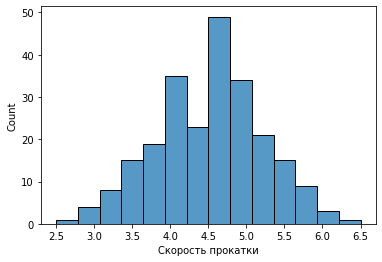

In [4]:
sns.histplot(x='Скорость прокатки', data=data)

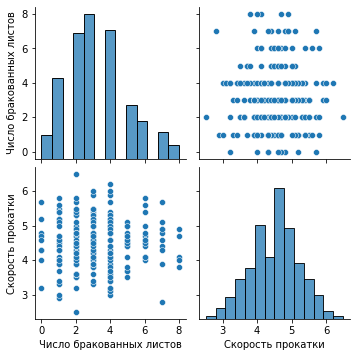

In [5]:
sns.pairplot(data)

### Гипотеза 1
* H0: отсутствует значимое различие брака между марками стали
* H1: присутствует разница между браком марок стали

In [6]:
from scipy.stats import ttest_ind
mark_a = data[(data['Марка стали'] == 'A') & 
              (data['Число бракованных листов'] > 3)]['Число бракованных листов']
mark_b = data[(data['Марка стали'] == 'B') & 
              (data['Число бракованных листов'] > 3)]['Число бракованных листов']
stat, p = ttest_ind(mark_a, mark_b)

print('Марка А\n', mark_a.describe())
print('Марка B\n', mark_b.describe())
print(stat, 'p-значение:', p)

Марка А
 count    53.000000
mean      5.113208
std       1.339638
min       4.000000
25%       4.000000
50%       5.000000
75%       6.000000
max       8.000000
Name: Число бракованных листов, dtype: float64
Марка B
 count    44.000000
mean      4.886364
std       1.104239
min       4.000000
25%       4.000000
50%       4.000000
75%       6.000000
max       8.000000
Name: Число бракованных листов, dtype: float64
0.8979646072876029 p-значение: 0.3714746018609977


In [7]:
alpha = 0.05

result2 = ttest_ind(mark_a, mark_b)

print('p-значение', result2.pvalue)

if result2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение 0.3714746018609977
Не получилось отвергнуть нулевую гипотезу


p-значение настолько велико, что означает что с вероятностью > 37% различие в показателях брака марки А и B может получиться случайно.

### Гипотеза 2
* H0: отсутствует значимое различие брака от скорости прокатки
* H1: присутствует разница между браком от скорости прокатки

In [8]:
low_speed = data[(data['Скорость прокатки'] <= 4) & 
              (data['Число бракованных листов'] > 3)]['Число бракованных листов']
hight_speed = data[(data['Скорость прокатки'] > 4) & 
              (data['Число бракованных листов'] > 3)]['Число бракованных листов']
stat, p = ttest_ind(low_speed, hight_speed)

print('Скорость меньше 4\n', low_speed.describe())
print('Скорость больше 4\n', hight_speed.describe())
print(stat, 'p-значение:', p)

Скорость меньше 4
 count    23.000000
mean      4.869565
std       1.358621
min       4.000000
25%       4.000000
50%       4.000000
75%       5.000000
max       8.000000
Name: Число бракованных листов, dtype: float64
Скорость больше 4
 count    74.000000
mean      5.054054
std       1.203783
min       4.000000
25%       4.000000
50%       5.000000
75%       6.000000
max       8.000000
Name: Число бракованных листов, dtype: float64
-0.6225387975354859 p-значение: 0.535079103101503


In [9]:
alpha = 0.05

result2 = ttest_ind(low_speed, hight_speed)

print('p-значение', result2.pvalue)

if result2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение 0.535079103101503
Не получилось отвергнуть нулевую гипотезу


p-значение настолько велико, что означает что с вероятностью > 53% различие в показателях брака от скорости может получиться случайно.

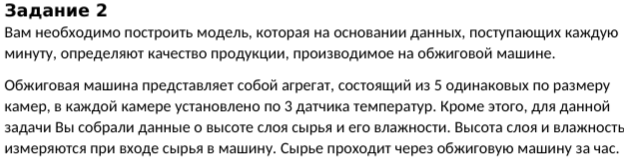

In [10]:
data_x = pd.read_csv('X_data.csv', sep=';')
data_x.head()

,Unnamed: 0,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
1,2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22
2,2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22
3,2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34,9.22
4,2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04,9.22


In [11]:
data_x.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103841 entries, 0 to 2103840
Data columns (total 18 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  2103841 non-null  object 
 1   T_data_1_1  2103841 non-null  int64  
 2   T_data_1_2  2103841 non-null  int64  
 3   T_data_1_3  2103841 non-null  int64  
 4   T_data_2_1  2103841 non-null  int64  
 5   T_data_2_2  2103841 non-null  int64  
 6   T_data_2_3  2103841 non-null  int64  
 7   T_data_3_1  2103841 non-null  int64  
 8   T_data_3_2  2103841 non-null  int64  
 9   T_data_3_3  2103841 non-null  int64  
 10  T_data_4_1  2103841 non-null  int64  
 11  T_data_4_2  2103841 non-null  int64  
 12  T_data_4_3  2103841 non-null  int64  
 13  T_data_5_1  2103841 non-null  int64  
 14  T_data_5_2  2103841 non-null  int64  
 15  T_data_5_3  2103841 non-null  int64  
 16  H_data      2103841 non-null  float64
 17  AH_data     2103841 non-null  float64
dtypes: float64(2), int64(1

Пропусков в данных нет.

In [12]:
data_y = pd.read_csv('Y_train.csv', sep=';', header=None, index_col=0)
data_y.head()

,1
0,
2015-01-04 00:05:00,392
2015-01-04 01:05:00,384
2015-01-04 02:05:00,393
2015-01-04 03:05:00,399
2015-01-04 04:05:00,400


In [13]:
submit_y = pd.read_csv('Y_submit.csv', sep=';', header=None, index_col=0)
submit_y.head()

,1
0,
2018-05-04 00:05:00,420
2018-05-04 01:05:00,420
2018-05-04 02:05:00,420
2018-05-04 03:05:00,420
2018-05-04 04:05:00,420


In [14]:
data_x = data_x.set_index(['Unnamed: 0'])
data_x.head(2)

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
Unnamed: 0,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22


In [15]:
#датафрейм из данных, в котором метрики качества известны
X = data_x.loc[data_x.index.isin(data_y.index)]
X.shape, data_y.shape

((29184, 17), (29184, 1))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, data_y, test_size=0.30, shuffle=False)

### CatBoost

Подбор занимал долго времени, закомментировал

%%time

parametrs = { 'n_estimators': range (1000, 2000, 100),
              'learning_rate': [0.03, 0.05, 0.07, 0.1],
              'depth': range (1,8,1) }

grid_ctb = GridSearchCV(CatBoostRegressor(random_state=12345, silent=True), 
                    parametrs, cv=5, scoring='neg_mean_absolute_error', refit=False, n_jobs=-1)
best_grid = grid_ctb.fit(X_train, y_train)
params = grid_ctb.best_params_
print('Best parameters is:', params)
print('Best score is:', abs(grid_ctb.best_score_))

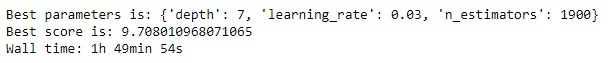

In [17]:
cb = CatBoostRegressor(depth=7, learning_rate=0.03, n_estimators=1900, random_state=12345)
cb.fit(X_train, y_train)
pred_test = cb.predict(X_test)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

0:	learn: 44.9309209	total: 61.1ms	remaining: 1m 56s
1:	learn: 43.9152704	total: 71.5ms	remaining: 1m 7s
2:	learn: 42.9556525	total: 79.8ms	remaining: 50.5s
3:	learn: 42.0013359	total: 88.7ms	remaining: 42s
4:	learn: 41.1012543	total: 97.5ms	remaining: 37s
5:	learn: 40.2168578	total: 106ms	remaining: 33.6s
6:	learn: 39.3598780	total: 116ms	remaining: 31.3s
7:	learn: 38.5300951	total: 125ms	remaining: 29.5s
8:	learn: 37.7234159	total: 133ms	remaining: 27.9s
9:	learn: 36.9320289	total: 141ms	remaining: 26.7s
10:	learn: 36.1646089	total: 150ms	remaining: 25.7s
11:	learn: 35.4304812	total: 158ms	remaining: 24.9s
12:	learn: 34.7257323	total: 167ms	remaining: 24.3s
13:	learn: 34.0264412	total: 176ms	remaining: 23.7s
14:	learn: 33.3644840	total: 184ms	remaining: 23.2s
15:	learn: 32.7154615	total: 193ms	remaining: 22.7s
16:	learn: 32.0994940	total: 202ms	remaining: 22.4s
17:	learn: 31.4910664	total: 210ms	remaining: 22s
18:	learn: 30.9171341	total: 219ms	remaining: 21.6s
19:	learn: 30.3791105	

164:	learn: 13.5374695	total: 1.62s	remaining: 17s
165:	learn: 13.5257181	total: 1.63s	remaining: 17s
166:	learn: 13.5166125	total: 1.64s	remaining: 17s
167:	learn: 13.5058495	total: 1.65s	remaining: 17s
168:	learn: 13.4961605	total: 1.66s	remaining: 17s
169:	learn: 13.4861799	total: 1.67s	remaining: 17s
170:	learn: 13.4703885	total: 1.68s	remaining: 17s
171:	learn: 13.4611346	total: 1.69s	remaining: 17s
172:	learn: 13.4527391	total: 1.7s	remaining: 16.9s
173:	learn: 13.4426707	total: 1.71s	remaining: 16.9s
174:	learn: 13.4322058	total: 1.71s	remaining: 16.9s
175:	learn: 13.4229540	total: 1.72s	remaining: 16.9s
176:	learn: 13.4153245	total: 1.73s	remaining: 16.8s
177:	learn: 13.4058211	total: 1.74s	remaining: 16.8s
178:	learn: 13.3986927	total: 1.75s	remaining: 16.8s
179:	learn: 13.3917402	total: 1.76s	remaining: 16.8s
180:	learn: 13.3855449	total: 1.77s	remaining: 16.8s
181:	learn: 13.3766371	total: 1.78s	remaining: 16.8s
182:	learn: 13.3696927	total: 1.79s	remaining: 16.8s
183:	learn

334:	learn: 12.6421201	total: 3.12s	remaining: 14.6s
335:	learn: 12.6398284	total: 3.13s	remaining: 14.6s
336:	learn: 12.6378606	total: 3.14s	remaining: 14.6s
337:	learn: 12.6324676	total: 3.15s	remaining: 14.6s
338:	learn: 12.6256532	total: 3.16s	remaining: 14.5s
339:	learn: 12.6224339	total: 3.17s	remaining: 14.5s
340:	learn: 12.6159864	total: 3.17s	remaining: 14.5s
341:	learn: 12.6132608	total: 3.18s	remaining: 14.5s
342:	learn: 12.6104154	total: 3.19s	remaining: 14.5s
343:	learn: 12.6072300	total: 3.2s	remaining: 14.5s
344:	learn: 12.6036582	total: 3.21s	remaining: 14.5s
345:	learn: 12.6015805	total: 3.22s	remaining: 14.4s
346:	learn: 12.5992126	total: 3.22s	remaining: 14.4s
347:	learn: 12.5963696	total: 3.23s	remaining: 14.4s
348:	learn: 12.5925929	total: 3.24s	remaining: 14.4s
349:	learn: 12.5862175	total: 3.25s	remaining: 14.4s
350:	learn: 12.5836692	total: 3.26s	remaining: 14.4s
351:	learn: 12.5812251	total: 3.27s	remaining: 14.4s
352:	learn: 12.5798336	total: 3.28s	remaining: 

503:	learn: 12.0915015	total: 4.88s	remaining: 13.5s
504:	learn: 12.0882357	total: 4.89s	remaining: 13.5s
505:	learn: 12.0829640	total: 4.91s	remaining: 13.5s
506:	learn: 12.0813927	total: 4.92s	remaining: 13.5s
507:	learn: 12.0790328	total: 4.93s	remaining: 13.5s
508:	learn: 12.0748938	total: 4.94s	remaining: 13.5s
509:	learn: 12.0724373	total: 4.95s	remaining: 13.5s
510:	learn: 12.0699388	total: 4.96s	remaining: 13.5s
511:	learn: 12.0673439	total: 4.97s	remaining: 13.5s
512:	learn: 12.0645744	total: 4.99s	remaining: 13.5s
513:	learn: 12.0631026	total: 5s	remaining: 13.5s
514:	learn: 12.0616135	total: 5.03s	remaining: 13.5s
515:	learn: 12.0600236	total: 5.05s	remaining: 13.5s
516:	learn: 12.0549363	total: 5.06s	remaining: 13.5s
517:	learn: 12.0504263	total: 5.07s	remaining: 13.5s
518:	learn: 12.0468107	total: 5.08s	remaining: 13.5s
519:	learn: 12.0452019	total: 5.09s	remaining: 13.5s
520:	learn: 12.0419459	total: 5.09s	remaining: 13.5s
521:	learn: 12.0344929	total: 5.1s	remaining: 13.

676:	learn: 11.6737844	total: 6.43s	remaining: 11.6s
677:	learn: 11.6721345	total: 6.44s	remaining: 11.6s
678:	learn: 11.6704631	total: 6.45s	remaining: 11.6s
679:	learn: 11.6682908	total: 6.46s	remaining: 11.6s
680:	learn: 11.6630168	total: 6.46s	remaining: 11.6s
681:	learn: 11.6608343	total: 6.47s	remaining: 11.6s
682:	learn: 11.6592170	total: 6.48s	remaining: 11.6s
683:	learn: 11.6573294	total: 6.49s	remaining: 11.5s
684:	learn: 11.6559018	total: 6.5s	remaining: 11.5s
685:	learn: 11.6533895	total: 6.51s	remaining: 11.5s
686:	learn: 11.6514204	total: 6.51s	remaining: 11.5s
687:	learn: 11.6496433	total: 6.52s	remaining: 11.5s
688:	learn: 11.6487225	total: 6.53s	remaining: 11.5s
689:	learn: 11.6457051	total: 6.54s	remaining: 11.5s
690:	learn: 11.6411231	total: 6.55s	remaining: 11.5s
691:	learn: 11.6389450	total: 6.56s	remaining: 11.4s
692:	learn: 11.6373834	total: 6.57s	remaining: 11.4s
693:	learn: 11.6327950	total: 6.58s	remaining: 11.4s
694:	learn: 11.6285376	total: 6.58s	remaining: 

837:	learn: 11.3522278	total: 7.79s	remaining: 9.88s
838:	learn: 11.3516401	total: 7.8s	remaining: 9.87s
839:	learn: 11.3505372	total: 7.81s	remaining: 9.86s
840:	learn: 11.3473477	total: 7.82s	remaining: 9.84s
841:	learn: 11.3465612	total: 7.83s	remaining: 9.83s
842:	learn: 11.3445514	total: 7.83s	remaining: 9.82s
843:	learn: 11.3427341	total: 7.84s	remaining: 9.81s
844:	learn: 11.3414958	total: 7.85s	remaining: 9.8s
845:	learn: 11.3396117	total: 7.86s	remaining: 9.79s
846:	learn: 11.3383992	total: 7.87s	remaining: 9.78s
847:	learn: 11.3372986	total: 7.88s	remaining: 9.77s
848:	learn: 11.3356541	total: 7.88s	remaining: 9.76s
849:	learn: 11.3343588	total: 7.89s	remaining: 9.75s
850:	learn: 11.3326827	total: 7.9s	remaining: 9.74s
851:	learn: 11.3308558	total: 7.91s	remaining: 9.73s
852:	learn: 11.3276624	total: 7.92s	remaining: 9.72s
853:	learn: 11.3259198	total: 7.92s	remaining: 9.71s
854:	learn: 11.3245290	total: 7.93s	remaining: 9.7s
855:	learn: 11.3231169	total: 7.94s	remaining: 9.6

1005:	learn: 11.0888584	total: 9.3s	remaining: 8.27s
1006:	learn: 11.0867639	total: 9.31s	remaining: 8.26s
1007:	learn: 11.0855928	total: 9.32s	remaining: 8.25s
1008:	learn: 11.0846405	total: 9.33s	remaining: 8.24s
1009:	learn: 11.0840453	total: 9.34s	remaining: 8.23s
1010:	learn: 11.0824791	total: 9.35s	remaining: 8.22s
1011:	learn: 11.0809811	total: 9.35s	remaining: 8.21s
1012:	learn: 11.0798194	total: 9.36s	remaining: 8.2s
1013:	learn: 11.0790039	total: 9.37s	remaining: 8.19s
1014:	learn: 11.0777809	total: 9.38s	remaining: 8.18s
1015:	learn: 11.0761126	total: 9.38s	remaining: 8.17s
1016:	learn: 11.0740947	total: 9.39s	remaining: 8.16s
1017:	learn: 11.0726280	total: 9.4s	remaining: 8.15s
1018:	learn: 11.0715544	total: 9.41s	remaining: 8.14s
1019:	learn: 11.0705075	total: 9.42s	remaining: 8.13s
1020:	learn: 11.0693963	total: 9.43s	remaining: 8.12s
1021:	learn: 11.0679381	total: 9.44s	remaining: 8.11s
1022:	learn: 11.0669497	total: 9.44s	remaining: 8.1s
1023:	learn: 11.0653241	total: 9

1171:	learn: 10.8348150	total: 10.9s	remaining: 6.74s
1172:	learn: 10.8340406	total: 10.9s	remaining: 6.74s
1173:	learn: 10.8327094	total: 10.9s	remaining: 6.74s
1174:	learn: 10.8322706	total: 10.9s	remaining: 6.73s
1175:	learn: 10.8307768	total: 10.9s	remaining: 6.72s
1176:	learn: 10.8286915	total: 10.9s	remaining: 6.71s
1177:	learn: 10.8263608	total: 10.9s	remaining: 6.71s
1178:	learn: 10.8253889	total: 11s	remaining: 6.7s
1179:	learn: 10.8222402	total: 11s	remaining: 6.69s
1180:	learn: 10.8208433	total: 11s	remaining: 6.68s
1181:	learn: 10.8195014	total: 11s	remaining: 6.67s
1182:	learn: 10.8185790	total: 11s	remaining: 6.66s
1183:	learn: 10.8177773	total: 11s	remaining: 6.65s
1184:	learn: 10.8167316	total: 11s	remaining: 6.64s
1185:	learn: 10.8145866	total: 11s	remaining: 6.63s
1186:	learn: 10.8127158	total: 11s	remaining: 6.62s
1187:	learn: 10.8113016	total: 11s	remaining: 6.61s
1188:	learn: 10.8098916	total: 11s	remaining: 6.61s
1189:	learn: 10.8079569	total: 11.1s	remaining: 6.5

1325:	learn: 10.6286518	total: 12.2s	remaining: 5.29s
1326:	learn: 10.6260525	total: 12.2s	remaining: 5.28s
1327:	learn: 10.6249743	total: 12.2s	remaining: 5.27s
1328:	learn: 10.6224900	total: 12.2s	remaining: 5.26s
1329:	learn: 10.6215871	total: 12.2s	remaining: 5.25s
1330:	learn: 10.6183633	total: 12.3s	remaining: 5.24s
1331:	learn: 10.6169726	total: 12.3s	remaining: 5.23s
1332:	learn: 10.6154557	total: 12.3s	remaining: 5.22s
1333:	learn: 10.6132715	total: 12.3s	remaining: 5.21s
1334:	learn: 10.6122890	total: 12.3s	remaining: 5.2s
1335:	learn: 10.6112359	total: 12.3s	remaining: 5.19s
1336:	learn: 10.6097841	total: 12.3s	remaining: 5.18s
1337:	learn: 10.6084372	total: 12.3s	remaining: 5.17s
1338:	learn: 10.6072267	total: 12.3s	remaining: 5.16s
1339:	learn: 10.6061956	total: 12.3s	remaining: 5.15s
1340:	learn: 10.6052765	total: 12.3s	remaining: 5.14s
1341:	learn: 10.6038996	total: 12.3s	remaining: 5.13s
1342:	learn: 10.6023867	total: 12.4s	remaining: 5.12s
1343:	learn: 10.6003104	total

1483:	learn: 10.4262389	total: 13.6s	remaining: 3.8s
1484:	learn: 10.4253746	total: 13.6s	remaining: 3.79s
1485:	learn: 10.4248704	total: 13.6s	remaining: 3.78s
1486:	learn: 10.4234906	total: 13.6s	remaining: 3.77s
1487:	learn: 10.4221886	total: 13.6s	remaining: 3.77s
1488:	learn: 10.4210922	total: 13.6s	remaining: 3.76s
1489:	learn: 10.4199638	total: 13.6s	remaining: 3.75s
1490:	learn: 10.4175719	total: 13.6s	remaining: 3.74s
1491:	learn: 10.4162420	total: 13.6s	remaining: 3.73s
1492:	learn: 10.4145728	total: 13.6s	remaining: 3.72s
1493:	learn: 10.4130872	total: 13.7s	remaining: 3.71s
1494:	learn: 10.4120294	total: 13.7s	remaining: 3.7s
1495:	learn: 10.4105050	total: 13.7s	remaining: 3.69s
1496:	learn: 10.4099122	total: 13.7s	remaining: 3.68s
1497:	learn: 10.4086599	total: 13.7s	remaining: 3.67s
1498:	learn: 10.4071943	total: 13.7s	remaining: 3.66s
1499:	learn: 10.4057729	total: 13.7s	remaining: 3.65s
1500:	learn: 10.4041080	total: 13.7s	remaining: 3.64s
1501:	learn: 10.4010287	total:

1641:	learn: 10.2137661	total: 14.9s	remaining: 2.34s
1642:	learn: 10.2123575	total: 14.9s	remaining: 2.33s
1643:	learn: 10.2111327	total: 14.9s	remaining: 2.33s
1644:	learn: 10.2099128	total: 14.9s	remaining: 2.31s
1645:	learn: 10.2090665	total: 14.9s	remaining: 2.31s
1646:	learn: 10.2079799	total: 15s	remaining: 2.3s
1647:	learn: 10.2071837	total: 15s	remaining: 2.29s
1648:	learn: 10.2064189	total: 15s	remaining: 2.28s
1649:	learn: 10.2044419	total: 15s	remaining: 2.27s
1650:	learn: 10.2030258	total: 15s	remaining: 2.26s
1651:	learn: 10.2017266	total: 15s	remaining: 2.25s
1652:	learn: 10.2005355	total: 15s	remaining: 2.24s
1653:	learn: 10.2005101	total: 15s	remaining: 2.23s
1654:	learn: 10.1994767	total: 15s	remaining: 2.22s
1655:	learn: 10.1985739	total: 15s	remaining: 2.21s
1656:	learn: 10.1973890	total: 15s	remaining: 2.21s
1657:	learn: 10.1971912	total: 15s	remaining: 2.2s
1658:	learn: 10.1958526	total: 15.1s	remaining: 2.19s
1659:	learn: 10.1940212	total: 15.1s	remaining: 2.18s


1797:	learn: 10.0371301	total: 16.2s	remaining: 921ms
1798:	learn: 10.0363095	total: 16.2s	remaining: 912ms
1799:	learn: 10.0338391	total: 16.3s	remaining: 903ms
1800:	learn: 10.0328928	total: 16.3s	remaining: 894ms
1801:	learn: 10.0299965	total: 16.3s	remaining: 885ms
1802:	learn: 10.0293345	total: 16.3s	remaining: 876ms
1803:	learn: 10.0268883	total: 16.3s	remaining: 867ms
1804:	learn: 10.0258471	total: 16.3s	remaining: 858ms
1805:	learn: 10.0243242	total: 16.3s	remaining: 849ms
1806:	learn: 10.0237772	total: 16.3s	remaining: 840ms
1807:	learn: 10.0227560	total: 16.3s	remaining: 831ms
1808:	learn: 10.0220636	total: 16.3s	remaining: 821ms
1809:	learn: 10.0206289	total: 16.3s	remaining: 812ms
1810:	learn: 10.0190655	total: 16.3s	remaining: 803ms
1811:	learn: 10.0172994	total: 16.4s	remaining: 794ms
1812:	learn: 10.0165585	total: 16.4s	remaining: 785ms
1813:	learn: 10.0153849	total: 16.4s	remaining: 776ms
1814:	learn: 10.0141863	total: 16.4s	remaining: 767ms
1815:	learn: 10.0130484	tota

Итоговый датасет состоит из 17 признаков и 29184 строк. Обучающая и тестовая выборка разбиты в соотношении 70:30.

In [18]:
submit_x = data_x.loc[data_x.index.isin(submit_y.index)]

Y_pred = pd.DataFrame(cb.predict(submit_x), index=submit_y.index)
Y_pred.head()

,0
0,
2018-05-04 00:05:00,444.688416
2018-05-04 01:05:00,443.156399
2018-05-04 02:05:00,427.098301
2018-05-04 03:05:00,406.466365
2018-05-04 04:05:00,410.779229


In [19]:
Y_pred.to_csv('Y_pred.csv', header=None)